# Cross-correlation and Auto-correlation

### George Tzanetakis, University of Victoria 

In this notebook we look into cross-correlation and auto-correlation 
as ways of matching signals in noise as well as estimating fundamental frequency. 

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal 
from scipy.interpolate import interp1d 

import IPython.display as ipd

Let's also load an audio recording

In [2]:
import scipy.io.wavfile as wav
srate, audio_signal = wav.read("amazing_grace_female.wav")
# scale to -1.0/1.0 
melody = audio_signal.astype(np.float32) / 32767.0 
# make max be 0.9 
melody = (0.9 / max(melody)) * melody


We will do our experiments on a short segment of the recording 
so that we can visualize things better

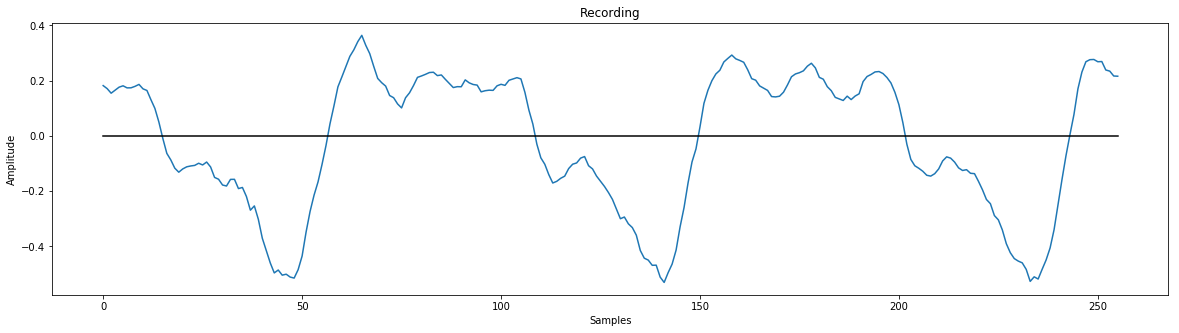

In [3]:
hopSize = 256
winSize = 256

# let's plot the 40th window 
o = 40 * hopSize 
frame = melody[o:o+winSize]

plt.figure(figsize=(20,5)) 
plt.title('Recording')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(frame)
plt.plot(np.zeros(len(frame)), color='black')
plt.show()

Let's create a longer signal with noise and insert the frame from above in it by summing. We can also see the original frame in red. 

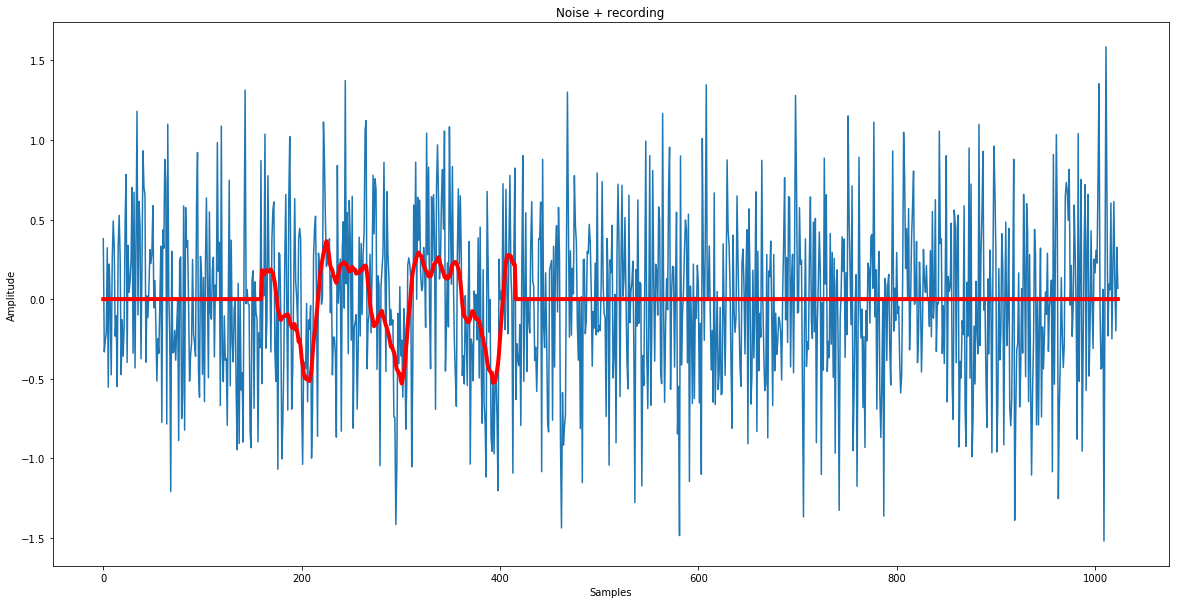

In [4]:
with_noise = np.random.normal(0, 0.5, 1024)
with_silence = np.zeros(1024)
shift = 160 

# add the fragment to the noise signal 
for i in range(shift, shift+len(frame)): 
    with_noise[i] = with_noise[i] + frame[i-shift]
    with_silence[i] = frame[i-shift]

plt.figure(figsize=(20,10)) 
plt.title('Noise + recording')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.plot(with_noise)
plt.plot(with_silence, color='red', linewidth=4)
plt.show()

The following plot illustrates visually the sliding followed by taking the inner product (point-wise multiplication and summing across) that takes place in cross-correlation. Only a subset of the shifts 
are shown. 

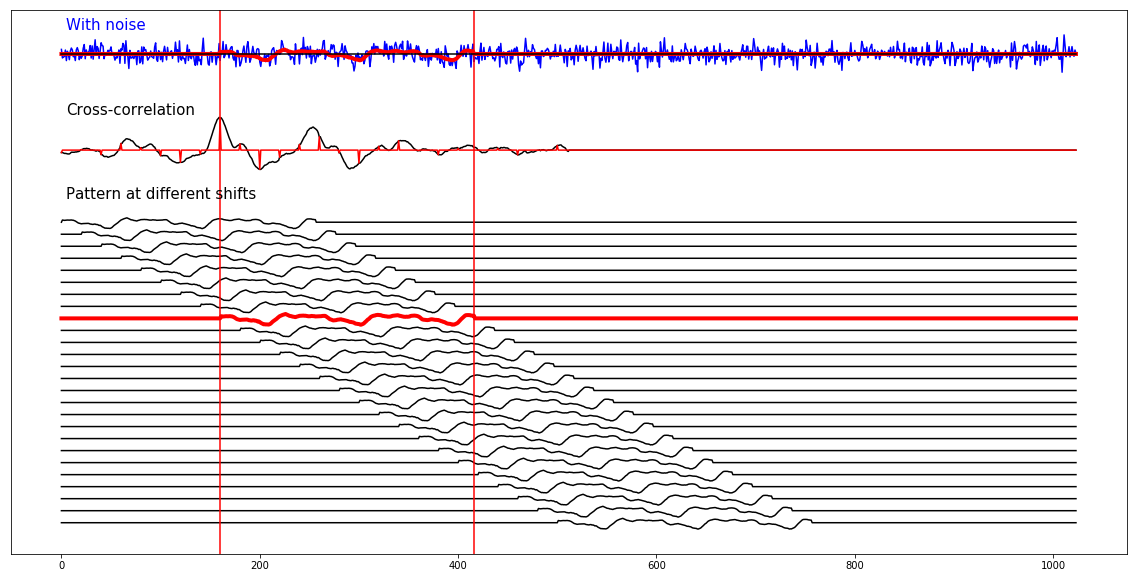

In [5]:
plt.figure(figsize=(20,10)) 

plt.text(5,2, 'With noise', fontsize=15, color='blue')
plt.text(5,-5, 'Cross-correlation', fontsize=15, color='black')
plt.text(5,-12, 'Pattern at different shifts', fontsize=15, color='black')


plt.plot(with_noise, color='blue')
plt.plot(with_silence, color='red', linewidth=4)

shifted = np.roll(with_silence,-shift)
cross_correlation = np.zeros(1024)
sampled_cross = np.zeros(1024)

for i in np.arange(0, 512, 1): 
    cross_correlation[i] = np.dot(with_noise, shifted)
    shifted = np.roll(shifted, 1)
    
    plot_every = 20 
    if (np.mod(i, plot_every)==0):
        plt.plot(shifted -14 - i/plot_every, color='black')
        sampled_cross[i] = cross_correlation[i] = np.dot(with_noise, shifted)

   # if (i==0): 
   #     plt.plot(shift_silence * 2 -14)
    if (i==shift): 
        plt.plot(shifted -14 - i/plot_every, color='red', linewidth=4)
   #    
   # if (i==200): 
   #     plt.plot(shift_silence * 2 -22)
    

plt.plot((0.2 * cross_correlation)-8,color='black')
plt.plot((0.2 * sampled_cross)-8, color='red')
plt.yticks([])
plt.axvline(x=shift,  color='red')
plt.axvline(x=shift+256,  color='red')
plt.plot(np.zeros(len(with_noise)), color='black')
plt.show()

A common textbook definition of autocorrelation is: 

$$c[k] = \sum_{n} a[n+k] * v[n]$$

Observe that for any particular shift k the value of the cross-correlation 
function at that k corresponds to a dot product.
We can use the numpy.correlate function to perform cross-correlation and 
estimate the location of a signal inside noise. This technique 
is called matched filtering. 


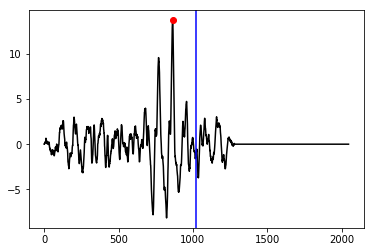

Estimated shift = 161.000000



In [6]:
shift = 160 
shifted = np.roll(with_silence,-shift)
cross_corr = np.correlate(shifted, with_noise, mode='full')
plt.figure()
plt.plot(cross_corr,color='black')
plt.plot(np.argmax(cross_corr), np.max(cross_corr), 'o', color='red')
plt.axvline(1024, color='blue')
plt.show()
print("Estimated shift = %f\n" % (len(with_noise) - np.argmax(cross_corr)))


When a signal is correlated with itself - the operation is called auto-correlation. 
Let's look at how this works. We will use a slightly longer frame of the audio recording 
to capture a few periods. Then we plot the autocorrelation function. Notice that 
the full auto-correlation contains both negative and positive shifts but we only 
care about one half. Also the highest peak is going to be at lag/shift 0 where the signal 
matches exactly itself. The second highest peak corresponds to the period of the underlying signal. 

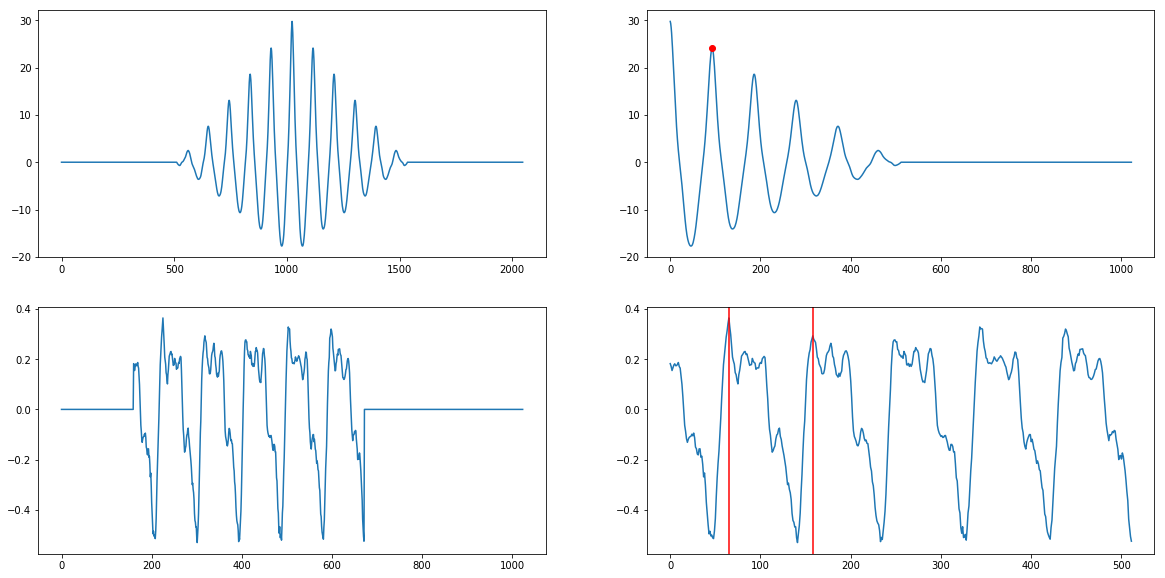

Estimated period = 93.000000 samples 


In [7]:
hopSize = 256
winSize = 512

# let's plot the 40th window 
o = 40 * hopSize 
frame = melody[o:o+winSize]

with_silence = np.zeros(1024)
shift = 160 

# add the fragment to the noise signal 
for i in range(shift, shift+len(frame)): 
    with_silence[i] = frame[i-shift]


plt.figure(figsize=(20,10)) 
acorr = np.correlate(with_silence, with_silence, mode='full')
plt.subplot(221)
plt.plot(acorr)
plt.subplot(222)
plt.plot(acorr[int(len(acorr)/2):])
plt.plot(93, acorr[int(len(acorr)/2):][93], "o", color="red")
plt.subplot(223)
plt.plot(with_silence)
plt.subplot(224)
plt.plot(with_silence[shift:shift+len(frame)])
plt.axvline(65, color='red')
plt.axvline(65+93, color='red')
plt.show()

# skip 50 samples so that argmax does not detect the peak at zero lag 
skip = 50 
print("Estimated period = %f samples " % (skip + np.argmax(acorr[int(len(acorr)/2)+skip:])))